In [1]:
%pip install torchgeo tensorboard pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip show torchgeo

Name: torchgeo
Version: 0.4.1
Summary: TorchGeo: datasets, samplers, transforms, and pre-trained models for geospatial data
Home-page: https://github.com/microsoft/torchgeo
Author: Adam J. Stewart
Author-email: ajstewart426@gmail.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: einops, fiona, kornia, lightning, matplotlib, numpy, pillow, pyproj, rasterio, rtree, scikit-learn, segmentation-models-pytorch, shapely, timm, torch, torchmetrics, torchvision
Required-by: 


In [2]:
%matplotlib inline
%load_ext tensorboard

import os
from torchvision.transforms import Compose
from torchgeo.datasets import RasterDataset,stack_samples,unbind_samples
from torchgeo.datasets.utils import download_url

from torchgeo.transforms import indices,AugmentationSequential
import kornia.augmentation as K

from torchgeo.samplers import RandomGeoSampler
from torch.utils.data import DataLoader

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torchgeo.datamodules import NAIPChesapeakeDataModule
import torch
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from torchgeo.trainers import SemanticSegmentationTask
from os import path
import torch.nn as nn
import torchvision.transforms as T
from pytorch_lightning.loggers import CSVLogger

import torchgeo
from lightning.pytorch import LightningDataModule
from torchgeo.datasets import BoundingBox

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
root='/content/gdrive/MyDrive/dataset/naipNdelaware4seg'
imagery_data=os.path.join(root, "imagery") # 存储NAIP航拍影像数据
LC_data=os.path.join(root, "LC") # 存储NAIP土地覆盖分类数据
data_dir=os.path.join(root, "training") # 存储模型训练过程和结果文件

In [ ]:
naipEntityID_selection_fn=os.path.join(root,'naipEntityID_selection.txt')
with open(naipEntityID_selection_fn,'r') as f:
    naipEntityID_selection=f.readlines()
naipEntityID_selection=[line.rstrip() for line in naipEntityID_selection]
naipEntityID_selection

['m_3807505_se_18_060_20180827.tif',
 'm_3807505_sw_18_060_20180815.tif',
 'm_3807504_se_18_060_20180815.tif',
 'm_3807504_sw_18_060_20180815.tif',
 'm_3807532_nw_18_060_20180815.tif',
 'm_3807531_nw_18_060_20180815.tif',
 'm_3807531_ne_18_060_20180815.tif']

In [ ]:
naip_38075_url=("https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/")

naip_download_rul=lambda url,tile,root:download_url(url+tile,root)
for tile in naipEntityID_selection:
    try:
        naip_download_rul(naip_38075_url,tile,imagery_data)
    except:
        print(f'Can not access to:{tile}')

Using downloaded and verified file: /content/gdrive/MyDrive/dataset/naipNdelaware4seg/imagery/m_3807505_se_18_060_20180827.tif
Using downloaded and verified file: /content/gdrive/MyDrive/dataset/naipNdelaware4seg/imagery/m_3807505_sw_18_060_20180815.tif
Using downloaded and verified file: /content/gdrive/MyDrive/dataset/naipNdelaware4seg/imagery/m_3807504_se_18_060_20180815.tif
Using downloaded and verified file: /content/gdrive/MyDrive/dataset/naipNdelaware4seg/imagery/m_3807504_sw_18_060_20180815.tif


100%|██████████| 489103340/489103340 [00:42<00:00, 11388534.38it/s]


100%|██████████| 497914540/497914540 [00:44<00:00, 11290614.87it/s]


100%|██████████| 467740726/467740726 [00:40<00:00, 11532384.15it/s]


In [ ]:
chesapeakebay_landcover_url="https://cicwebresources.blob.core.windows.net/chesapeakebaylandcover"
base_folder="DE"
zipfile="_DE_STATEWIDE.zip"
chesapeakebay_landcover_url += f"/{base_folder}/{zipfile}"

In [ ]:
download_url(chesapeakebay_landcover_url, LC_data, filename=zipfile)

Using downloaded and verified file: /content/gdrive/MyDrive/dataset/naipNdelaware4seg/LC/_DE_STATEWIDE.zip


In [5]:
import tarfile
from typing import (
    Any,
    Dict,
    Iterable,
    Iterator,
    List,
    Optional,
    Sequence,
    Tuple,
    Union,
    cast,
    overload,
)

class _rarfile:
    class RarFile:
        def __init__(self, *args: Any, **kwargs: Any) -> None:
            self.args = args
            self.kwargs = kwargs

        def __enter__(self) -> Any:
            try:
                import rarfile
            except ImportError:
                raise ImportError(
                    "rarfile is not installed and is required to extract this dataset"
                )

            # TODO: catch exception for when rarfile is installed but not
            # unrar/unar/bsdtar
            return rarfile.RarFile(*self.args, **self.kwargs)

        def __exit__(self, exc_type: None, exc_value: None, traceback: None) -> None:
            pass


class _zipfile:
    class ZipFile:
        def __init__(self, *args: Any, **kwargs: Any) -> None:
            self.args = args
            self.kwargs = kwargs

        def __enter__(self) -> Any:
            try:
                # Supports normal zip files, proprietary deflate64 compression algorithm
                import zipfile_deflate64 as zipfile
            except ImportError:
                # Only supports normal zip files
                # https://github.com/python/mypy/issues/1153
                import zipfile  # type: ignore[no-redef]

            return zipfile.ZipFile(*self.args, **self.kwargs)

        def __exit__(self, exc_type: None, exc_value: None, traceback: None) -> None:
            pass


def extract_archive(src: str, dst: Optional[str] = None) -> None:
    """Extract an archive.

    Args:
        src: file to be extracted
        dst: directory to extract to (defaults to dirname of ``src``)

    Raises:
        RuntimeError: if src file has unknown archival/compression scheme
    """
    if dst is None:
        dst = os.path.dirname(src)

    suffix_and_extractor: List[Tuple[Union[str, Tuple[str, ...]], Any]] = [
        (".rar", _rarfile.RarFile),
        (
            (".tar", ".tar.gz", ".tar.bz2", ".tar.xz", ".tgz", ".tbz2", ".tbz", ".txz"),
            tarfile.open,
        ),
        (".zip", _zipfile.ZipFile),
    ]

    for suffix, extractor in suffix_and_extractor:
        if src.endswith(suffix):
            with extractor(src, "r") as f:
                f.extractall(dst)
            return

    suffix_and_decompressor: List[Tuple[str, Any]] = [
        (".bz2", bz2.open),
        (".gz", gzip.open),
        (".xz", lzma.open),
    ]

    for suffix, decompressor in suffix_and_decompressor:
        if src.endswith(suffix):
            dst = os.path.join(dst, os.path.basename(src).replace(suffix, ""))
            with decompressor(src, "rb") as sf, open(dst, "wb") as df:
                df.write(sf.read())
            return

    raise RuntimeError("src file has unknown archival/compression scheme")

In [6]:
extract_archive(os.path.join(LC_data, zipfile))

NameError: ignored

In [7]:
# 迁移于TorchGeo库：torchgeo.datamodules.naip模块

def chesapeake_transform(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Transform a single sample from the Chesapeake Dataset.

    Args:
        sample: Chesapeake mask dictionary

    Returns:
        preprocessed Chesapeake data
    """
    sample["mask"] = sample["mask"].long()[0]

    return sample

def remove_bbox(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Removes the bounding box property from a sample.

    Args:
        sample: dictionary with geographic metadata

    Returns
        sample without the bbox property
    """
    del sample["bbox"]
    return sample

def labes_merge(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Merge land cover classifications.

    Args:
        sample: dictionary with geographic metadata

    Returns
        sample without the bbox property
    """
    label_merge_mapping={
                        0:0, # Null
                        1:1, # Water ->Water
                        2:2, # Emergent Wetlands -> Emergent Wetlands
                        3:3, # Tree Canopy -> Tree Canopy
                        4:4, # Scrub/Shrub -> Scrub/Shrub
                        5:4, # Low Vegetation -> Scrub/Shrub
                        6:5, # Barren -> Barren(6->5)
                        7:6, # Impervious Structures -> Impervious Structures(7->6)
                        8:6, # Other Impervious -> Impervious Structures(7->6)
                        9:6, # Impervious Road -> Impervious Road(9->7)
                        10:3, # Tree Canopy over Impervious Structure -> Tree Canopy
                        11:3, # Tree Canopy over Other Impervious -> Tree Canopy
                        12:3, # Tree Canopy over Impervious Roads -> Tree Canopy
                        254:7, # Aberdeen Proving Ground -> Aberdeen Proving Ground(254->8)
                        }

    old=sample["mask"]
    indexer=np.array([label_merge_mapping.get(i, -1) for i in range(old.min(), old.max() + 1)])
    new=torch.from_numpy(indexer[(old - old.min())])
    sample["mask"]=new
    return sample

In [8]:
chesapeak_transforms=Compose([chesapeake_transform,remove_bbox,labes_merge])

class delaware_lc_rd(RasterDataset):
    filename_glob="DE_STATEWIDE.tif"
    is_image=False

chesapeake=delaware_lc_rd(LC_data,transforms=chesapeak_transforms)

In [9]:
print(f"crs:{chesapeake.crs}\nres:{chesapeake.res}")

crs:ESRI:102039
res:1.0


In [10]:
from typing import Optional

import torch
from kornia.augmentation import IntensityAugmentationBase2D
from torch import Tensor

_EPSILON = 1e-10


class AppendNormalizedDifferenceIndex(IntensityAugmentationBase2D):
    r"""Append normalized difference index as channel to image tensor.

    Computes the following index:

    .. math::

       \text{NDI} = \frac{A - B}{A + B}

    .. versionadded:: 0.2
    """

    def __init__(self, index_a: int, index_b: int) -> None:
        """Initialize a new transform instance.

        Args:
            index_a: reference band channel index
            index_b: difference band channel index
        """
        super().__init__(p=1)
        self.flags = {"index_a": index_a, "index_b": index_b}

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, int],
        transform: Optional[Tensor] = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        band_a = input[..., flags["index_a"], :, :]
        band_b = input[..., flags["index_b"], :, :]
        ndi = (band_a - band_b) / (band_a + band_b + _EPSILON)
        ndi = torch.unsqueeze(ndi, -3)
        input = torch.cat((input, ndi), dim=-3)
        return input[0]

class AppendNDVI(AppendNormalizedDifferenceIndex):
    r"""Normalized Difference Vegetation Index (NDVI).

    Computes the following index:

    .. math::

       \text{NDVI} = \frac{\text{NIR} - \text{R}}{\text{NIR} + \text{R}}

    If you use this index in your research, please cite the following paper:

    * https://doi.org/10.1016/0034-4257(79)90013-0
    """

    def __init__(self, index_nir: int, index_red: int) -> None:
        """Initialize a new transform instance.

        Args:
            index_nir: index of the Near Infrared (NIR) band in the image
            index_red: index of the Red band in the image
        """
        super().__init__(index_a=index_nir, index_b=index_red)

class AppendNDWI(AppendNormalizedDifferenceIndex):
    r"""Normalized Difference Water Index (NDWI).

    Computes the following index:

    .. math::

       \text{NDWI} = \frac{\text{G} - \text{NIR}}{\text{G} + \text{NIR}}

    If you use this index in your research, please cite the following paper:

    * https://doi.org/10.1080/01431169608948714
    """

    def __init__(self, index_green: int, index_nir: int) -> None:
        """Initialize a new transform instance.

        Args:
            index_green: index of the Green band in the image
            index_nir: index of the Near Infrared (NIR) band in the image
        """
        super().__init__(index_a=index_green, index_b=index_nir)

In [11]:
def naip_preprocess(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Transform a single sample from the NAIP Dataset.

    Args:
        sample: NAIP image dictionary

    Returns:
        preprocessed NAIP data
    """
    sample["image"] = sample["image"].float()
    sample["image"] /= 255.0

    return sample

class naip_rd(RasterDataset):
    filename_glob = "m_*.*"
    filename_regex = r"""
        ^m
        _(?P<quadrangle>\d+)
        _(?P<quarter_quad>[a-z]+)
        _(?P<utm_zone>\d+)
        _(?P<resolution>\d+)
        _(?P<date>\d+)
        (?:_(?P<processing_date>\d+))?
        \..*$
    """
    is_image=True
    all_bands = ["R", "G", "B", "NIR"]
    rgb_bands = ["R", "G", "B"]

ndvi=AppendNDVI(index_nir=3, index_red=0)
ndwi=AppendNDWI(index_green=1, index_nir=3)

naip_transforms=Compose([
    naip_preprocess,
    remove_bbox,
    AugmentationSequential(ndvi,data_keys=["image"])
    ])

naip=naip_rd(imagery_data,chesapeake.crs,chesapeake.res,transforms=naip_transforms)

In [12]:
print(f"crs:{naip.crs}\nres:{naip.res}")

crs:ESRI:102039
res:1.0


In [13]:
dataset=chesapeake & naip

In [14]:
sampler=RandomGeoSampler(dataset,size=256, length=10)
dataloader=DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    print(sample.keys())
    print(sample['image'].shape)
    break

dict_keys(['crs', 'mask', 'image'])
torch.Size([5, 256, 256])


dict_keys(['crs', 'mask', 'image'])
torch.Size([6, 256, 256])


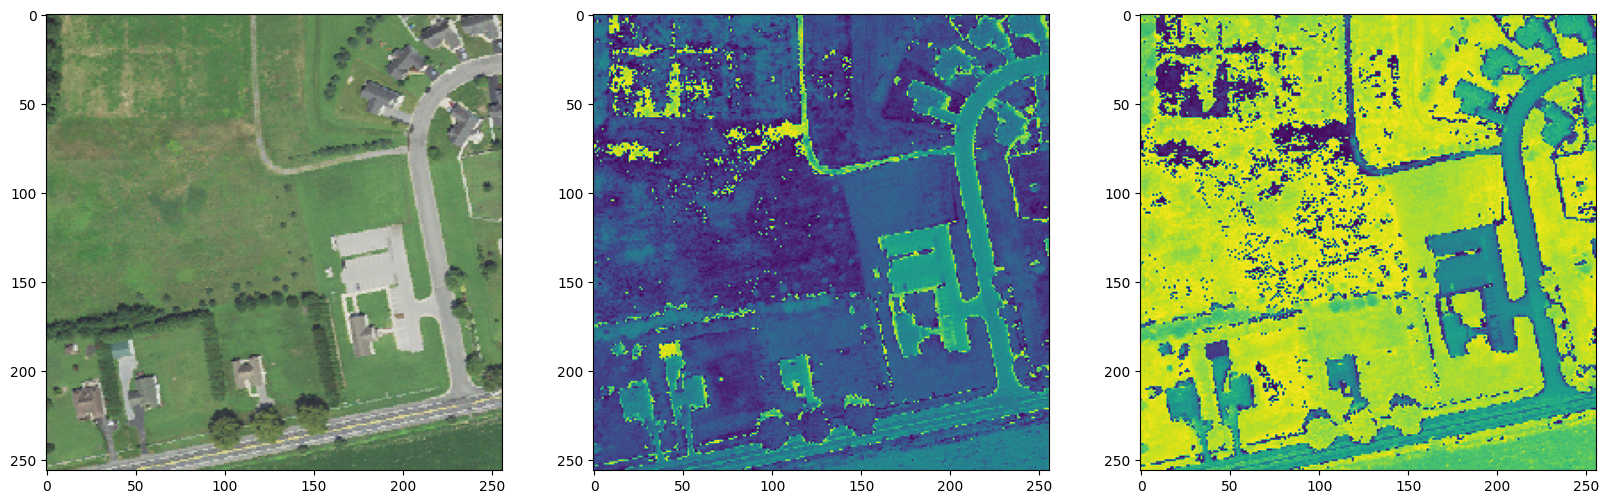

In [ ]:
sampler=RandomGeoSampler(dataset,size=256, length=10)
dataloader=DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    print(sample.keys())
    print(sample['image'].shape)

    fig, axes= plt.subplots(1, 3,figsize=(20,10))
    axes[0].imshow(T.ToPILImage()(sample['image'][:3]))
    axes[1].imshow(T.ToPILImage()(sample['image'][4]))
    axes[2].imshow(T.ToPILImage()(sample['image'][5]))
    plt.show()

    break

In [ ]:
sample['image']

tensor([[[0.3765, 0.3255, 0.3059,  ..., 0.1725, 0.1922, 0.2078],
         [0.1412, 0.2157, 0.2431,  ..., 0.2039, 0.2039, 0.2863],
         [0.1569, 0.2667, 0.2980,  ..., 0.1922, 0.2353, 0.3059],
         ...,
         [0.1804, 0.1882, 0.1882,  ..., 0.3373, 0.3608, 0.2941],
         [0.1490, 0.1608, 0.1647,  ..., 0.2627, 0.2863, 0.1843],
         [0.1725, 0.1922, 0.2745,  ..., 0.2667, 0.1961, 0.2118]],

        [[0.4353, 0.3843, 0.3922,  ..., 0.2000, 0.2235, 0.2235],
         [0.1922, 0.2627, 0.3098,  ..., 0.2000, 0.2353, 0.3961],
         [0.1922, 0.3608, 0.3882,  ..., 0.2196, 0.3098, 0.4118],
         ...,
         [0.2235, 0.2314, 0.2667,  ..., 0.4706, 0.4784, 0.3922],
         [0.1608, 0.1804, 0.1765,  ..., 0.3608, 0.4157, 0.2235],
         [0.1922, 0.2314, 0.3765,  ..., 0.3255, 0.1804, 0.2549]],

        [[0.3137, 0.2941, 0.2824,  ..., 0.2235, 0.2314, 0.2549],
         [0.2314, 0.2588, 0.2706,  ..., 0.2353, 0.2431, 0.3098],
         [0.2196, 0.2745, 0.2980,  ..., 0.2392, 0.2784, 0.

In [ ]:
np.unique(sample['mask'])

array([3, 4, 5, 6, 7])

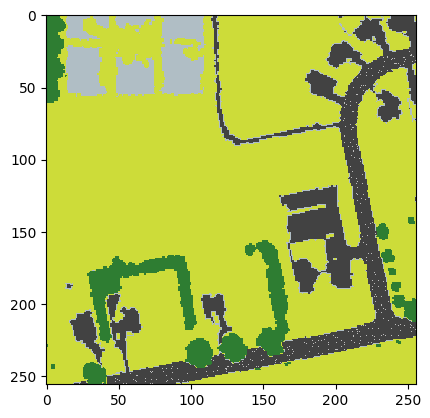

In [ ]:
LC_color_dict={
    #0: (0, 0, 0, 0),
    #1: (30, 136, 229,255),
    #2: (230, 238, 156, 255),
    3: (46, 125, 50,255),
    4: (205, 220, 57, 255),
    5: (176, 190, 197, 255),
    6: (66, 66, 66, 255),
    7: (189, 189, 189, 255),
    #8: (255, 255, 255, 255),
    }

cmap_LC, norm=matplotlib.colors.from_levels_and_colors(list(LC_color_dict.keys()),[[v/255 for v in i] for i in LC_color_dict.values()],extend='max')
plt.imshow(np.squeeze(sample['mask']),cmap=cmap_LC);

In [15]:
class geo_datamodule(LightningDataModule):
    """LightningDataModule implementation for the TorchGeo datasets.

    Uses the train/val/test splits from the dataset.
    """
    # TODO: tune these hyperparams
    length=1000
    stride=128

    def __init__(
        self,
        ds_image: torchgeo.datasets,
        ds_label: torchgeo.datasets,
        batch_size: int=64,
        num_workers: int=0,
        patch_size: int=256,
        **kwargs: Any,
    ) -> None:
        """Initialize a LightningDataModule for TorchGeo dataset based DataLoaders.

        Args:
            ds_image: Image dataset in TorchGeo RasterDataset format
            ds_label: Target(label) dataset in TorchGeo RasterDataset format
            batch_size: The batch size to use in all created DataLoaders
            num_workers: The number of workers to use in all created DataLoaders
            patch_size: size of patches to sample
        """
        super().__init__()
        self.ds_image=ds_image
        self.ds_label=ds_label
        self.batch_size=batch_size
        self.num_workers=num_workers
        self.patch_size=patch_size

    def setup(self, stage: Optional[str] = None) -> None:
        """Initialize the main ``Dataset`` objects.

        This method is called once per GPU per run.

        Args:
            stage: state to set up
        """
        # TODO: these transforms will be applied independently, this won't work if we
        # add things like random horizontal flip

        # TODO: figure out better train/val/test split
        self.dataset = self.ds_label & self.ds_image
        roi=self.dataset.bounds
        midx=roi.minx + (roi.maxx - roi.minx) / 2
        midy=roi.miny + (roi.maxy - roi.miny) / 2
        train_roi=BoundingBox(roi.minx, midx, roi.miny, roi.maxy, roi.mint, roi.maxt)
        val_roi=BoundingBox(midx, roi.maxx, roi.miny, midy, roi.mint, roi.maxt)
        test_roi=BoundingBox(roi.minx, roi.maxx, midy, roi.maxy, roi.mint, roi.maxt)

        self.train_sampler=RandomBatchGeoSampler(
            self.ds_image, self.patch_size, self.batch_size, self.length, train_roi
        )
        self.val_sampler = GridGeoSampler(self.ds_image, self.patch_size, self.stride, val_roi)
        self.test_sampler = GridGeoSampler(self.ds_image, self.patch_size, self.stride, test_roi)

    def train_dataloader(self) -> DataLoader[Any]:
        """Return a DataLoader for training.

        Returns:
            training data loader
        """

        return DataLoader(
            self.dataset,
            batch_sampler=self.train_sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        """Return a DataLoader for validation.

        Returns:
            validation data loader
        """

        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            sampler=self.val_sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        """Return a DataLoader for testing.

        Returns:
            testing data loader
        """

        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            sampler=self.test_sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples,
        )

    def plot(
        self,
        sample: dict[str, Any],
        show_titles: bool = True,
        suptitle: Optional[str] = None,
    ) -> plt.Figure:
        """Plot a sample from the dataset.

        Args:
            sample: a sample returned by :meth:`RasterDataset.__getitem__`
            show_titles: flag indicating whether to show titles above each panel
            suptitle: optional string to use as a suptitle

        Returns:
            a matplotlib Figure with the rendered sample

        .. versionchanged:: 0.3
           Method now takes a sample dict, not a Tensor. Additionally, possible to
           show subplot titles and/or use a custom suptitle.
        """
        image = sample["image"][0:3, :, :].permute(1, 2, 0)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

        ax.imshow(image)
        ax.axis("off")
        if show_titles:
            ax.set_title("Image")

        if suptitle is not None:
            plt.suptitle(suptitle)

        return fig


In [16]:
datamodule=geo_datamodule(
    ds_image=naip,
    ds_label=chesapeake,
    batch_size=64,
    patch_size=256
    )

aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    # classes=8,                 # define number of output labels
)

task=SemanticSegmentationTask(
    model='unet',
    backbone='resnet34',
    weights='imagenet',
    pretrained=True,
    in_channels=5, # 6,
    num_classes=8,
    ignore_index=0,#7
    loss='ce', # 'jaccard'
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
    aux_params=aux_params,
    )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 17.6MB/s]


In [17]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

checkpoint_callback=ModelCheckpoint(monitor="val_loss", dirpath=data_dir, save_top_k=1, save_last=True) #,save_on_train_epoch_end=True
early_stopping_callback=EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)
#logger=CSVLogger(save_dir=data_dir, name="segmentation_unet")
logger=TensorBoardLogger(save_dir=data_dir, name="tensorboard_logs",version=1,)

in_tests="PYTEST_CURRENT_TEST" in os.environ

trainer=Trainer(
    callbacks=[checkpoint_callback,early_stopping_callback],
    logger=logger,
    default_root_dir=data_dir,
    min_epochs=1,
    max_epochs=300,
    fast_dev_run=in_tests,
    accelerator=accelerator,
    #limit_val_batches=500,
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [18]:
from os import path
from torchgeo.samplers.batch import RandomBatchGeoSampler
from torchgeo.samplers.single import GridGeoSampler

ckpt_path=os.path.join(data_dir,'last.ckpt')
if path.exists(ckpt_path):
    print('ckpt file exists.')
    trainer.fit(model=task,datamodule=datamodule,ckpt_path=ckpt_path)
else:
    trainer.fit(model=task,datamodule=datamodule)

ckpt file exists.


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/gdrive/MyDrive/dataset/naipNdelaware4seg/training exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/gdrive/MyDrive/dataset/naipNdelaware4seg/training/last.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 24.4 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
24.4 M    Trainable params
0         

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower va

Training: 15it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%tensorboard --logdir "$data_dir"

Launching TensorBoard...

In [ ]:
import csv

if not in_tests:
    train_steps = []
    train_rmse = []

    val_steps = []
    val_rmse = []
    with open(
        os.path.join(data_dir, "segmentation_unet", "version_0", "metrics.csv"), "r"
    ) as f:
        csv_reader = csv.DictReader(f, delimiter=",")
        for i, row in enumerate(csv_reader):
            # print(row)
            try:
                train_rmse.append(float(row["train_loss"]))
                train_steps.append(i)
            except ValueError:  # Ignore rows where train RMSE is empty
                pass

            try:
                val_rmse.append(float(row["val_MulticlassAccuracy"]))
                val_steps.append(i)
            except ValueError:  # Ignore rows where val RMSE is empty
                pass

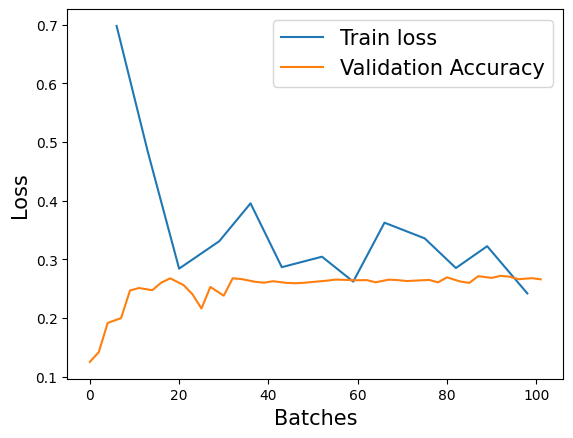

In [ ]:
import matplotlib.pyplot as plt

if not in_tests:
    plt.figure()
    plt.plot(train_steps, train_rmse, label="Train loss")
    plt.plot(val_steps, val_rmse, label="Validation Accuracy")
    plt.legend(fontsize=15)
    plt.xlabel("Batches", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.show()
    plt.close()

---

In [20]:
trainer.test(model=task, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │      0.362870454788208      │
│ test_MulticlassJaccardIndex │     0.35294270515441895     │
│          test_loss          │     0.45782798528671265     │
└─────────────────────────────┴─────────────────────────────┘

[{'test_loss': 0.45782798528671265,
  'test_MulticlassAccuracy': 0.362870454788208,
  'test_MulticlassJaccardIndex': 0.35294270515441895}]

In [ ]:
from torchgeo.samplers import GridGeoSampler,RandomGeoSampler
from torchgeo.datasets import NAIP,stack_samples
from torch.utils.data import DataLoader
import torch

X_pre=NAIP(r'/content/gdrive/MyDrive/dataset/naipNdelaware4seg/delaware_imagery_temp',transforms=naip_transforms)
X_sample=RandomGeoSampler(X_pre, size=1024,length=100)
X_dataloader=DataLoader(X_pre, sampler=X_sample, collate_fn=stack_samples)
X_dataloader_=iter(X_dataloader)

In [ ]:
X_batch=next(X_dataloader_)
X=X_batch["image"]#.float()

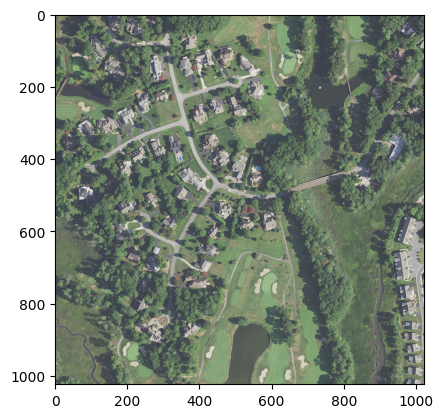

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

plt.imshow(T.ToPILImage()(X[0][:3]));

In [ ]:
unet_model=task.load_from_checkpoint(os.path.join(data_dir,'last.ckpt'))
unet_model.freeze()

In [ ]:
y_probs=unet_model(X)
print(y_probs.shape)

torch.Size([1, 8, 1024, 1024])


In [ ]:
import numpy as np
y_pred=np.argmax(y_probs,axis=1)#.reshape(-1,1)
print(y_pred.shape,'\n',y_pred,'\n',y_pred.unique())

torch.Size([1, 1024, 1024]) 
 tensor([[[4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         ...,
         [4, 4, 4,  ..., 6, 6, 4],
         [4, 4, 4,  ..., 6, 4, 4],
         [4, 4, 4,  ..., 6, 4, 4]]]) 
 tensor([3, 4, 6])


In [ ]:
LC_color_dict={
    #0: (0, 0, 0, 0),
    #1: (30, 136, 229,255),
    #2: (230, 238, 156, 255),
    3: (46, 125, 50,255),
    4: (205, 220, 57, 255),
    5: (176, 190, 197, 255),
    6: (66, 66, 66, 255),
    7: (189, 189, 189, 255),
    #8: (255, 255, 255, 255),
    }

cmap_LC, norm=matplotlib.colors.from_levels_and_colors(list(LC_color_dict.keys()),[[v/255 for v in i] for i in LC_color_dict.values()],extend='max')


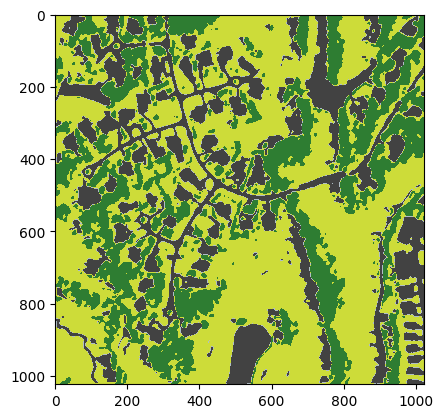

In [ ]:
import matplotlib
import numpy as np

plt.imshow(np.squeeze(y_pred),cmap=cmap_LC);